In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import os
import bz2
from src.QuoteBankData import QuoteBankData
from src.Deaths import Deaths
import src.utilities.quotebank_preprocessing_utils as utils
from src.CONSTS import DATA_PATH, COLORS, KEYWORDS_JSON_FILE_PATH, KEYWORDS_FILE_PATH, BEGIN_YEAR, END_YEAR
from tqdm import tqdm
from src.utilities.synonym_utils import add_new_synonyms
from src.utilities.add_features import expand_line
from src.utilities.utils import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import warnings
import collections

warnings.filterwarnings("ignore")

def save_meta_data_quotes():
    quotebank.quotes_occurrences_df = pd.DataFrame()
    for year in range(BEGIN_YEAR, END_YEAR + 1):
        if year == 2010: break
        dict_df_row = {"Year": year}
        for key in quotebank.keywords:
            file = key.output_filenames[year-BEGIN_YEAR]
            with open(file, 'rU') as f:
                quotes = pd.read_json(file, lines=True)
            if len(quotes) > 0:
                # Save total number of quotes per year per topic in df
                num_of_quotes = quotes["n_appearances"].sum()
                

                for _, line_quotes in quotes.iterrows():
                    # Safe number of quotes per topic per year per country of url
                    country_urls = line_quotes['country_urls']
                    for country in country_urls:
                        if country == "Great Britain":
                            country = "United Kingdom"
                        if (country, year) in key.country_url_occurences:
                            key.country_url_occurences[(country, year)] += 1
                        else:
                            key.country_url_occurences[(country, year)] = 1

                    # Safe number of quotes per topic per year per country of speaker
                    country_speaker = line_quotes['country_speaker']
                    if country_speaker:
                        if isinstance(country_speaker, list):        # if multiple countries, take most occuring
                            country_speaker = collections.Counter(country_speaker).most_common(1)[0][0]

                        if (country_speaker,year) in key.country_speaker_occurences:
                            key.country_speaker_occurences[(country_speaker,year)] +=1
                        else:
                            key.country_speaker_occurences[(country_speaker,year)] = 1 
            else:
                num_of_quotes = 0
            dict_df_row[key.name] = num_of_quotes
            
        quotebank.quotes_occurrences_df = quotebank.quotes_occurrences_df.append(dict_df_row, ignore_index = True)
        cols = quotebank.quotes_occurrences_df.columns
        quotebank.quotes_occurrences_df[cols] = quotebank.quotes_occurrences_df[cols].astype(int)

In [151]:
def get_country_per_year_count(url_or_speaker, countries, percentage = False):
    # Check value
    if url_or_speaker != "url" and url_or_speaker != "speaker":
        raise ValueError("Did not choose url or speaker")
    
    # Initialize output
    topic_appearance_country = np.zeros((len(quotebank.keywords), len(countries)+1))
    topics = list()
    for i in range(len(quotebank.keywords)):
        topics.append(quotebank.keywords[i].name)
        if url_or_speaker == "url":
            for key in quotebank.keywords[i].country_url_occurences:
                if key[0] in english_countries:
                    topic_appearance_country[i, countries.index(key[0])] = quotebank.keywords[i].country_url_occurences[key]
                elif key[0] is not None:
                    topic_appearance_country[i, -1] += quotebank.keywords[i].country_url_occurences[key]
                    
        elif url_or_speaker == "speaker":
            for key in quotebank.keywords[i].country_speaker_occurences:
                if key[0] in english_countries:
                    topic_appearance_country[i, countries.index(key[0])] = quotebank.keywords[i].country_speaker_occurences[key]
                elif key[0] is not None:
                    topic_appearance_country[i, -1] += quotebank.keywords[i].country_speaker_occurences[key]
                
    if percentage:
        topic_appearance_country = np.transpose(topic_appearance_country/np.sum(topic_appearance_country, axis = 0))*100
    else:
        topic_appearance_country = np.transpose(topic_appearance_country)
    topic_appearance_country = pd.DataFrame(data = topic_appearance_country,
                                           columns = topics)
    
    return topic_appearance_country

In [152]:
def reduce_df(df_original, percentage_treshold):
    df = df_original.copy()
    df_percentage = df.copy()
    # Check if rows are percentages
    if int(df_percentage.loc[0].sum()) != 100:
        for index, row in df_percentage.iterrows():
            df_percentage.loc[index] = (row/row.sum()) * 100
        
    other = np.zeros(len(df))
    for column in df:
        if df_percentage[column].max() < percentage_treshold:
            other += df[column].values
            df.drop([column], axis=1, inplace=True)
    
    df = df.assign(Other=other)
    return df

In [153]:
def stacked_barplot(df, x_labels=None, y_label=None, title=None, width = 0.35):
    columns = df.columns
    fig, ax = plt.subplots()
    df_plot = df.cumsum(axis=1)
    for i in range(len(columns) ):
        index = len(columns) - 1 - i
        ax.bar(x_labels, df_plot[columns[index]].to_numpy(), width, label=columns[index])

    ax.set_ylabel(y_label)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


In [17]:
quotebank = QuoteBankData("Asymmetry of News", [])
quotebank.read_keywords_from_file()
utils.create_directories_for_every_year()
quotebank.create_json_dumps_filenames_for_each_keyword()

In [28]:
save_meta_data_quotes()

In [166]:
english_countries = ['United Kingdom', 'United States of America','Canada', 'Australia', 'India']
df_speaker = get_country_per_year_count("speaker", english_countries, percentage = False)
df_speaker = reduce_df(df_speaker, 5)
df_url = get_country_per_year_count("url", english_countries, percentage = False)
df_url = reduce_df(df_url, 5)


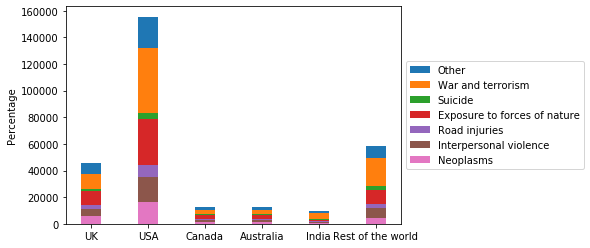

In [164]:
labels = english_countries
labels[1] = "USA"
labels[0] = "UK"
labels.append("Rest of the world")
stacked_barplot(df_speaker, labels, "Percentage")

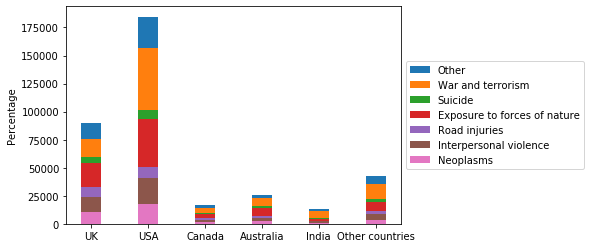

In [167]:
labels = english_countries
labels[1] = "USA"
labels[0] = "UK"
labels.append("Other countries")
stacked_barplot(df_url, labels, "Percentage")

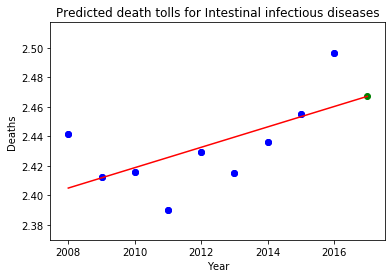

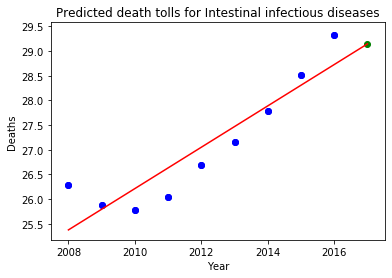

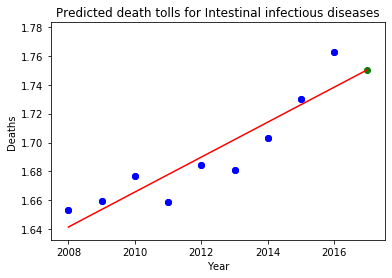

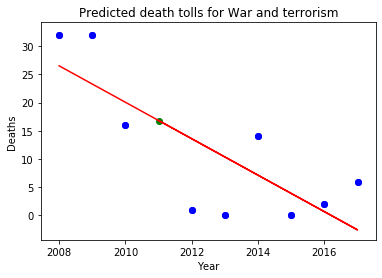

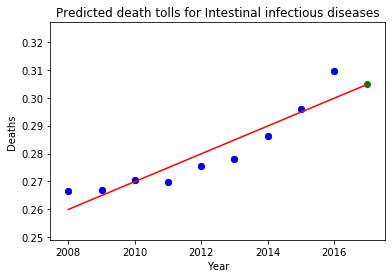

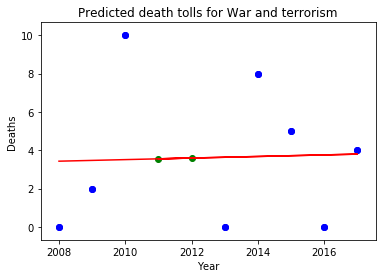

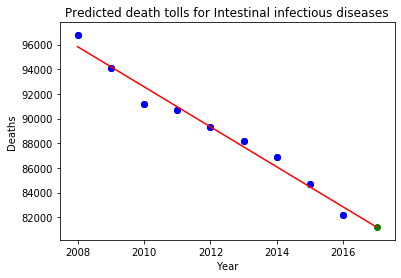

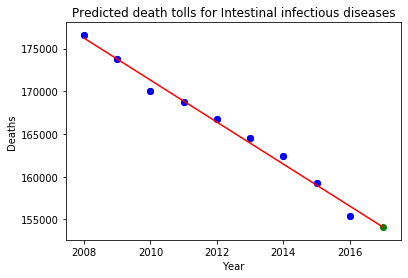

In [15]:
death_by_cause_path=  "data/annual_number_of_deaths_by_cause.csv"
countries = ['United Kingdom', 'United States','Canada', 'Australia', 'India','World']
deaths = list()
for country in countries:
    deaths.append(Deaths("deaths_by_cause", country, death_by_cause_path, rename_cols = {'Terrorism (deaths)': 'Terrorism', 'Deaths - Self-harm - Sex: Both - Age: All Ages (Number)': 'Suicide'}, drop_cols = ['Number of executions (Amnesty International)']))


In [16]:
deaths_2009 = pd.DataFrame()
topics = ['Meningitis', 'Lower respiratory infections',
       'Intestinal infectious diseases', 'Cardiovascular diseases',
       'Alzheimer disease and other dementias', 'Chronic kidney disease',
       'Chronic respiratory diseases',
       'Cirrhosis and other chronic liver diseases', 'Digestive diseases',
       'Hepatitis', 'Neoplasms', 'Parkinson disease',
       'Fire, heat, and hot substances', 'Malaria', 'Drowning',
       'Interpersonal violence', 'Hiv/aids', 'Tuberculosis', 'Road injuries',
       'Maternal disorders', 'Neonatal disorders', 'Diarrheal diseases',
       'Suicide', 'Diabetes mellitus', 'Poisonings', 'War and terrorism',
       'Exposure to forces of nature', 'Nutritional deficiencies',
       'Drug use and alcoholism']

NameError: name 'topics' is not defined